In [2]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torch.utils.data import DataLoader
import pickle
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import seaborn as sb
import torch.nn.functional as F
from collections import defaultdict

/Users/lixinmei/miniconda3/envs/aero/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

In [5]:
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [6]:
ds = pickle.load(open('/Users/lixinmei/Desktop/vscode_workspace/aeroimagery/AID/dataset.pkl', 'rb'))

In [7]:
# get all the image embeddings and text embeddings
# then train a model based on the embeddings
PREFIX = 'aero imagery of '

labels = ds.dataset.features['label'].names
prefixed_labels = [PREFIX + label for label in labels]

In [8]:
# ds[0]['image']

In [9]:
prefixed_labels

['aero imagery of Airport',
 'aero imagery of BareLand',
 'aero imagery of BaseballField',
 'aero imagery of Beach',
 'aero imagery of Bridge',
 'aero imagery of Center',
 'aero imagery of Church',
 'aero imagery of Commercial',
 'aero imagery of DenseResidential',
 'aero imagery of Desert',
 'aero imagery of Farmland',
 'aero imagery of Forest',
 'aero imagery of Industrial',
 'aero imagery of Meadow',
 'aero imagery of MediumResidential',
 'aero imagery of Mountain',
 'aero imagery of Park',
 'aero imagery of Parking',
 'aero imagery of Playground',
 'aero imagery of Pond',
 'aero imagery of Port',
 'aero imagery of RailwayStation',
 'aero imagery of Resort',
 'aero imagery of River',
 'aero imagery of School',
 'aero imagery of SparseResidential',
 'aero imagery of Square',
 'aero imagery of Stadium',
 'aero imagery of StorageTanks',
 'aero imagery of Viaduct']

In [20]:
processed_input = processor(prefixed_labels, ds[0]['image'], return_tensors="pt", padding=True)
# model (**processed_input)

In [21]:
# with torch.no_grad():
model_output = model(**processed_input)
img_embed = model_output.image_embeds
text_embed = model_output.text_embeds

In [22]:
model_output

CLIPOutput(loss=None, logits_per_image=tensor([[31.1383, 26.0887, 25.7570, 27.6885, 26.1272, 27.5133, 26.9227, 28.3340,
         26.0160, 25.3203, 25.3274, 23.5364, 27.6872, 26.5497, 26.9153, 24.6882,
         28.1070, 30.4681, 26.4436, 26.1856, 28.3079, 28.4610, 26.8980, 24.4026,
         27.2369, 25.6504, 28.5630, 26.9753, 24.4024, 26.1452]],
       grad_fn=<TBackward0>), logits_per_text=tensor([[31.1383],
        [26.0887],
        [25.7570],
        [27.6885],
        [26.1272],
        [27.5133],
        [26.9227],
        [28.3340],
        [26.0160],
        [25.3203],
        [25.3274],
        [23.5364],
        [27.6872],
        [26.5497],
        [26.9153],
        [24.6882],
        [28.1070],
        [30.4681],
        [26.4436],
        [26.1856],
        [28.3079],
        [28.4610],
        [26.8980],
        [24.4026],
        [27.2369],
        [25.6504],
        [28.5630],
        [26.9753],
        [24.4024],
        [26.1452]], grad_fn=<MulBackward0>), text_embeds

In [85]:
img_embed.shape, text_embed.shape

(torch.Size([1, 512]), torch.Size([30, 512]))

In [86]:
EMBEDDING_SIZE = 512

In [87]:
# image embeddings
image_embeddings = torch.Tensor((len(ds), EMBEDDING_SIZE))
text_embeddings = torch.Tensor((len(labels), EMBEDDING_SIZE))

In [88]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [89]:
# with torch.no_grad():
#     model_output = model(** processor(prefixed_labels, ds[:]['image'], return_tensors="pt", padding=True))

In [114]:
class BasePredictor(torch.nn.Module):

    def __init__(self, processor, model, prefixed_labels = prefixed_labels):
        super().__init__()
        self.processor = processor
        self.model = model
        self.prefixed_labels = prefixed_labels

    def forward(self, x):
        x_image = x['image']
        x_label = x['label']
        model_input = self.processor(self.prefixed_labels, x_image, return_tensors="pt", padding=True)
        model_output = self.model(**model_input)

        return model_output, x_label

In [115]:
class TrainClipDataset(torch.utils.data.Dataset):

    def __init__(self, ds, categories):
        self.ds = ds
        self.categories = categories
        self.base_index = list(range(0, len(self.ds), len(self.ds)//len(self.categories)))
        self.category_indices = [[] for cate in categories]
        for i, sample in tqdm(enumerate(self.ds), total=len(self.ds)):
            label = sample['label']
            self.category_indices[label].append(i)

    def __len__(self):
        return len(self.ds)//len(self.categories)

    def __getitem__(self, idx):
        # indexes = [i + idx for i in self.base_index]
        # return self.ds[indexes]
        indexes = [i[idx] for i in self.category_indices]
        return self.ds[indexes]
    
    

In [215]:
tds = TrainClipDataset(ds, labels)

100%|██████████| 1500/1500 [00:06<00:00, 226.85it/s]


In [216]:
tds[0]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x600>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x600>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.Image.Image image mode=RGB size=600x600>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RG

In [117]:
# tds

In [185]:
class Adaptor(torch.nn.Module):

    def __init__(self, seed=1050):
        super().__init__()
        self.linear = torch.nn.Linear(EMBEDDING_SIZE, EMBEDDING_SIZE)

    def forward(self, model_output, x_label):

        img_embedding = model_output.image_embeds
        text_embedding = model_output.text_embeds

        # print(img_embedding.shape, text_embedding.shape)
        adpated_image_embedding = self.linear(img_embedding)

        # print(f'{adpated_image_embedding.shape=}, {text_embedding.shape=}')
        adapted_logits = F.normalize(adpated_image_embedding, dim=1) @ F.normalize(text_embedding, dim=1).T
        
        # this comes from the pytorch implementation of CLIP
        adapted_logits = model.logit_scale.exp() * adapted_logits
        # one hot encoding of the true label
        true_logits = torch.nn.functional.one_hot(torch.tensor(x_label), num_classes=len(labels)).float().T
        # print(true_logits)
        # if len(true_logits.shape) == 1:
            # true_logits = true_logits.unsqueeze(0)

        return adapted_logits, true_logits


    def loss(self, pred, true):
        # for simplicity here, just use cross-entropy loss
        return F.cross_entropy(F.softmax(pred), true)


In [186]:
adaptor = Adaptor()
predictor = BasePredictor(processor, model)
for param in predictor.parameters():
    param.requires_grad = False

for param in adaptor.parameters():
    param.requires_grad = True

In [187]:
tds = TrainClipDataset(ds, labels)

100%|██████████| 1500/1500 [00:05<00:00, 250.16it/s]


In [188]:
train, test = torch.utils.data.random_split(tds, [0.6, 0.4])

In [189]:
len(train), len(test)

(30, 20)

In [190]:

optimizer = torch.optim.SGD(adaptor.parameters(), lr=1e-3)

bar = tqdm(total=len(train), desc='training linear adaptor')
for epoch in [1, 2]:
    for j in range(len(train)):
        i = tds[j]
        model_output, x_label = predictor(i)
        pred, true = adaptor(model_output, x_label)
        # loss = F.cross_entropy(F.softmax(pred, dim=0), true)
        # print(f'{pred.shape=}, {true.shape=}')
        loss = F.cross_entropy(pred, true)
        loss.backward()
        optimizer.step()
        # print(loss.item(), pred)
        bar.update(1)
        bar.set_postfix(loss=loss)

training linear adaptor: 52it [01:15,  1.45s/it, loss=tensor(0.4272, grad_fn=<DivBackward1>)]


In [192]:
with torch.no_grad():
    confusion_matrix = torch.zeros(len(prefixed_labels), len(prefixed_labels))
    bar = tqdm(total=len(test), desc='running prediction')
    # for batch in dl:
    for batch in test:
        # print(batch['label'])
        # logits = classifier(batch['image'])
        model_output, x_label = predictor(batch)
        pred, true = adaptor(model_output, x_label)
        # print(pred)
        # print(true)
        logits = torch.argmax(pred, dim=1)
        # print(logits)
        truth = batch['label']
        print(truth, logits)
        confusion_matrix[truth, logits] += 1
        # print(truth, logits)
        # bar.update(len(truth))
        bar.update(1)


        # print(ds.features['label'].names[logits])

training linear adaptor: 60it [01:08,  1.14s/it, loss=tensor(0.8956, grad_fn=<DivBackward1>)]
running prediction:   5%|▌         | 1/20 [00:00<00:17,  1.08it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 24, 13, 14, 15, 24, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  0, 29])


running prediction:  10%|█         | 2/20 [00:01<00:15,  1.13it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 24, 13, 14, 15, 16, 20,
        18, 19, 20, 21, 22,  4, 24, 22, 24, 27, 28, 29])


running prediction:  15%|█▌        | 3/20 [00:02<00:14,  1.14it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([20,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0, 13, 26, 15,  7, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 24, 18, 28, 29])


running prediction:  20%|██        | 4/20 [00:03<00:13,  1.17it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 22,  9, 10, 11, 12, 13,  4, 11, 16, 17,
        18,  4, 20,  0, 22, 23, 24, 25,  7,  5, 20, 29])


running prediction:  25%|██▌       | 5/20 [00:04<00:12,  1.17it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5, 24,  7,  8,  9, 10, 11, 20, 13, 14, 15,  7, 17,
        18, 19, 20,  0, 22, 23, 24, 10, 26, 18, 28, 29])


running prediction:  30%|███       | 6/20 [00:05<00:11,  1.19it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  9, 16, 20,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22,  4, 24, 25, 22, 24, 28, 29])


running prediction:  35%|███▌      | 7/20 [00:05<00:10,  1.21it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5, 24,  7,  8,  9, 10, 11,  7, 13,  8, 15, 24, 17,
        18, 19, 20, 21, 22, 23, 24, 22,  5,  5, 12, 29])


running prediction:  40%|████      | 8/20 [00:06<00:09,  1.21it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  0,  6,  7,  8,  9, 10, 11, 12, 13, 25, 15, 16, 17,
        24, 23, 20, 21, 22, 23, 24, 25, 24, 24, 20, 29])


running prediction:  45%|████▌     | 9/20 [00:07<00:09,  1.21it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  9,  2,  3,  4, 24, 24,  7,  8,  9, 10, 11, 12, 13, 14, 15,  7, 17,
        18, 19, 20, 21, 16, 23, 24, 22,  7, 18,  0, 29])


running prediction:  50%|█████     | 10/20 [00:08<00:08,  1.20it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5, 24, 24,  8,  9, 10, 11, 24, 13, 14, 15,  7, 17,
        18, 19, 20,  7, 22, 23, 24, 25, 26, 24, 28, 29])


running prediction:  55%|█████▌    | 11/20 [00:09<00:07,  1.20it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  9,  4,  5,  6, 24,  8,  9, 10, 11, 12, 13,  4, 15,  7, 17,
        18, 19, 20, 21, 22, 16, 24,  0, 24, 24, 28, 29])


running prediction:  60%|██████    | 12/20 [00:10<00:06,  1.19it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  7,  2,  3,  4,  5, 22,  7, 22,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 24, 28, 29])


running prediction:  65%|██████▌   | 13/20 [00:10<00:05,  1.19it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5, 24,  7,  8,  9,  7, 11,  7, 13,  8, 15, 16, 17,
        18, 23, 20, 21, 22, 23, 24, 22, 24, 27, 28, 29])


running prediction:  70%|███████   | 14/20 [00:11<00:04,  1.20it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4, 24, 24,  7,  8,  9, 10, 11, 12, 13, 14, 15, 22, 17,
        18, 19, 20, 21, 22, 23, 24, 22, 26, 27, 28, 29])


running prediction:  75%|███████▌  | 15/20 [00:12<00:04,  1.23it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1, 26,  3,  4, 24, 24,  7,  8,  9, 10, 11, 24, 13,  8, 15, 22, 17,
        24, 19, 20, 21, 22, 23, 24, 22, 26, 27,  5, 29])


running prediction:  80%|████████  | 16/20 [00:13<00:03,  1.24it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  9, 18,  3,  4,  5, 24, 24,  8,  9,  0, 11,  0, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  0,  4])


running prediction:  85%|████████▌ | 17/20 [00:14<00:02,  1.25it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0, 13,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  7, 17,
        18, 19, 20, 21, 22, 23, 24, 22, 26, 27, 28, 29])


running prediction:  90%|█████████ | 18/20 [00:14<00:01,  1.25it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 22,  9, 10, 11, 12, 13, 14, 15, 24, 17,
        18, 19, 20, 21,  7, 23, 24, 13, 26, 27, 20, 29])


running prediction:  95%|█████████▌| 19/20 [00:15<00:00,  1.22it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5, 24, 24,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21,  0, 23, 24, 25, 24, 18, 28,  4])


running prediction: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] tensor([ 0,  1,  2,  3,  4,  5, 24,  7,  8,  9, 10, 11, 24, 13, 25, 15, 16, 17,
        18, 19, 20, 21, 22, 10, 24, 25, 26, 27, 28, 29])


In [217]:
loss

tensor(0.9445, grad_fn=<DivBackward1>)

<Axes: >

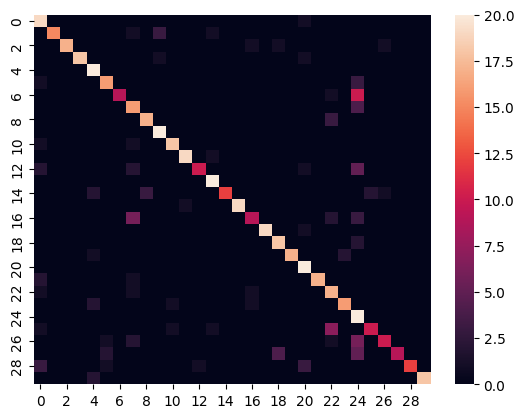

In [194]:
sb.heatmap(confusion_matrix)

In [195]:
# accuracy
tp = confusion_matrix.diag()
accuracy = tp.sum() / len(test) / len(prefixed_labels)
accuracy

tensor(0.7950)

In [196]:
class TwoLayerAdaptor(torch.nn.Module):

    def __init__(self, seed=1050, hidden_size=1024, activation='relu'):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear = torch.nn.Linear(EMBEDDING_SIZE, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, EMBEDDING_SIZE)
        self.activation = activation
        


    def forward(self, model_output, x_label):

        img_embedding = model_output.image_embeds
        text_embedding = model_output.text_embeds

        # print(img_embedding.shape, text_embedding.shape)
        adpated_image_embedding = self.linear(img_embedding)
        # activation
        adpated_image_embedding = torch.nn.functional.relu(adpated_image_embedding)
        adpated_image_embedding = self.linear2(adpated_image_embedding)


        # print(f'{adpated_image_embedding.shape=}, {text_embedding.shape=}')
        adapted_logits = F.normalize(adpated_image_embedding, dim=1) @ F.normalize(text_embedding, dim=1).T
        
        # this comes from the pytorch implementation of CLIP
        adapted_logits = model.logit_scale.exp() * adapted_logits
        # one hot encoding of the true label
        true_logits = torch.nn.functional.one_hot(torch.tensor(x_label), num_classes=len(labels)).float().T
        # print(true_logits)
        # if len(true_logits.shape) == 1:
            # true_logits = true_logits.unsqueeze(0)

        return adapted_logits, true_logits


    def loss(self, pred, true):
        # for simplicity here, just use cross-entropy loss
        return F.cross_entropy(F.softmax(pred), true)

In [208]:
adaptor2 = TwoLayerAdaptor()
predictor = BasePredictor(processor, model)
for param in predictor.parameters():
    param.requires_grad = False

for param in adaptor2.parameters():
    param.requires_grad = True

In [209]:

optimizer = torch.optim.SGD(adaptor2.parameters(), lr=1e-3)

for epoch in range(2):
    bar = tqdm(total=len(train), desc=f'training 2-layer adaptor, {epoch=}')
    for j in range(len(train)):
        i = tds[j]
        model_output, x_label = predictor(i)
        pred, true = adaptor2(model_output, x_label)
        # loss = F.cross_entropy(F.softmax(pred, dim=0), true)
        # print(f'{pred.shape=}, {true.shape=}')
        loss = F.cross_entropy(pred, true)
        loss.backward()
        optimizer.step()
        
        # print(loss.item(), pred)
        bar.update(1)
        bar.set_postfix(loss=loss)
    print('')

training 2-layer adaptor, epoch=0: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, loss=tensor(1.8561, grad_fn=<DivBackward1>)]

training 2-layer adaptor, epoch=0: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, loss=tensor(1.8561, grad_fn=<DivBackward1>)]


In [210]:
with torch.no_grad():
    confusion_matrix = torch.zeros(len(prefixed_labels), len(prefixed_labels))
    bar = tqdm(total=len(test), desc='running prediction')
    # for batch in dl:
    for batch in test:
        # print(batch['label'])
        # logits = classifier(batch['image'])
        model_output, x_label = predictor(batch)
        pred, true = adaptor2(model_output, x_label)
        # print(pred)
        # print(true)
        logits = torch.argmax(pred, dim=1)
        # print(logits)
        truth = batch['label']
        # print(truth, logits)
        confusion_matrix[truth, logits] += 1
        # print(truth, logits)
        # bar.update(len(truth))
        bar.update(1)


        # print(ds.features['label'].names[logits])

running prediction: 100%|██████████| 20/20 [00:16<00:00,  1.16it/s]

<Axes: >

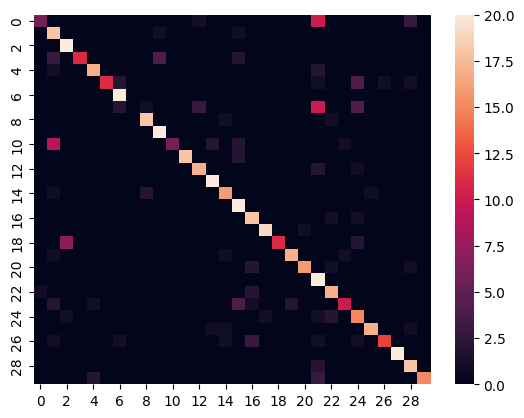

In [213]:
sb.heatmap(confusion_matrix)

In [214]:
# accuracy
tp = confusion_matrix.diag()
accuracy = tp.sum() / len(test) / len(prefixed_labels)
accuracy

tensor(0.7717)